## Importings

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D ,MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, Activation
from keras import Sequential
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.applications import VGG19
import matplotlib.pyplot as plt

## Reading data to dataframe

In [2]:
import zipfile

zip_path = "/content/Animal Image Classification Dataset.zip"
extract_path = "/content/animal_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset diekstrak ke:", extract_path)


Dataset diekstrak ke: /content/animal_dataset


In [5]:
import os
import pandas as pd

folder_path = "/content/animal_dataset/Animals"

file_paths = []
class_names = []
images = []

for class_name in os.listdir(folder_path):
    class_folder = os.path.join(folder_path, class_name)
    if os.path.isdir(class_folder):  # Ensure it's a folder
        for file in os.listdir(class_folder):
            file_path = os.path.join(class_folder, file)
            file_paths.append(file_path)
            class_names.append(class_name)
            # Using CV2
            img = cv2.imread(file_path)
            images.append(img)

df = pd.DataFrame({
    'path': file_paths,
    'class_name': class_names,
    'image': images
})

In [6]:
df.sample(10)

,path,class_name,image
2572,/content/animal_dataset/Animals/cats/0_0104.jpg,cats,"[[[127, 108, 135], [129, 110, 137], [131, 112,..."
2652,/content/animal_dataset/Animals/cats/0_0700.jpg,cats,"[[[45, 46, 44], [38, 39, 37], [33, 34, 32], [3..."
497,/content/animal_dataset/Animals/snakes/2_0515.jpg,snakes,"[[[63, 69, 80], [74, 83, 93], [79, 88, 98], [6..."
1525,/content/animal_dataset/Animals/dogs/1_0741.jpg,dogs,"[[[62, 64, 58], [67, 69, 63], [51, 53, 47], [3..."
370,/content/animal_dataset/Animals/snakes/2_0474.jpg,snakes,"[[[0, 0, 0], [14, 14, 14], [0, 0, 0], [0, 0, 0..."
1685,/content/animal_dataset/Animals/dogs/1_0139.jpg,dogs,"[[[171, 166, 168], [178, 173, 175], [187, 182,..."
688,/content/animal_dataset/Animals/snakes/2_0974.jpg,snakes,"[[[84, 114, 139], [124, 154, 179], [114, 144, ..."
597,/content/animal_dataset/Animals/snakes/2_0184.jpg,snakes,"[[[102, 127, 153], [104, 129, 155], [119, 144,..."
2787,/content/animal_dataset/Animals/cats/0_0047.jpg,cats,"[[[20, 25, 24], [20, 25, 24], [20, 25, 24], [2..."
395,/content/animal_dataset/Animals/snakes/2_0352.jpg,snakes,"[[[230, 224, 159], [234, 228, 163], [232, 226,..."


## Data Augmentation

In [7]:
IMG_HEIGHT, IMG_WIDTH = 256, 256
BATCH_SIZE = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,

)

train_generator = train_datagen.flow_from_dataframe(
    df,
    x_col='path',
    y_col='class_name',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training')

validation_generator = train_datagen.flow_from_dataframe(
    df,
    x_col='path',
    y_col='class_name',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='validation')

Found 2400 validated image filenames belonging to 3 classes.
Found 600 validated image filenames belonging to 3 classes.


In [8]:
train_size = train_generator.n
validation_size = validation_generator.n

print(f"Training set size (before augmentation): {train_size}")
print(f"Validation set size (before augmentation): {validation_size}")

Training set size (before augmentation): 2400
Validation set size (before augmentation): 600


In [9]:
train_steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps_per_epoch = validation_generator.samples // BATCH_SIZE

print(f"Training steps per epoch: {train_steps_per_epoch}")
print(f"Validation steps per epoch: {validation_steps_per_epoch}")

Training steps per epoch: 75
Validation steps per epoch: 18


In [11]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in base_model.layers:
    layer.trainable = False

vgg19 = Sequential()

vgg19.add(base_model)

vgg19.add(Flatten())
vgg19.add(Dense(128, activation='relu'))
vgg19.add(BatchNormalization())
vgg19.add(Dropout(0.5))

vgg19.add(Dense(64, activation='relu'))
vgg19.add(BatchNormalization())
vgg19.add(Dropout(0.3))

vgg19.add(Dense(3, activation='softmax'))

vgg19.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
es = EarlyStopping(monitor='loss', patience=3)

In [14]:
history = vgg19.fit(train_generator, epochs=50, callbacks=[es], validation_data=validation_generator)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 92s 936ms/step - accuracy: 0.5357 - loss: 1.1916 - val_accuracy: 0.4833 - val_loss: 0.9397
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 55s 733ms/step - accuracy: 0.6859 - loss: 0.7595 - val_accuracy: 0.8817 - val_loss: 0.2744
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 54s 724ms/step - accuracy: 0.7334 - loss: 0.6486 - val_accuracy: 0.9383 - val_loss: 0.1460
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 55s 734ms/step - accuracy: 0.7589 - loss: 0.5897 - val_accuracy: 0.9700 - val_loss: 0.0922
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 81s 726ms/step - accuracy: 0.7754 - loss: 0.5452 - val_accuracy: 0.9400 - val_loss: 0.1527
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.7931 - loss: 0.5221 - val_accuracy: 0.9233 - val_loss: 0.1918
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 55s 736ms/step - accuracy: 0.8077 - loss: 0.4877 - val_accuracy: 0.9000 - val_loss: 0.2286
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 55s 729ms/step - accuracy: 0.7986 - loss: 0.5031 - val_accurac

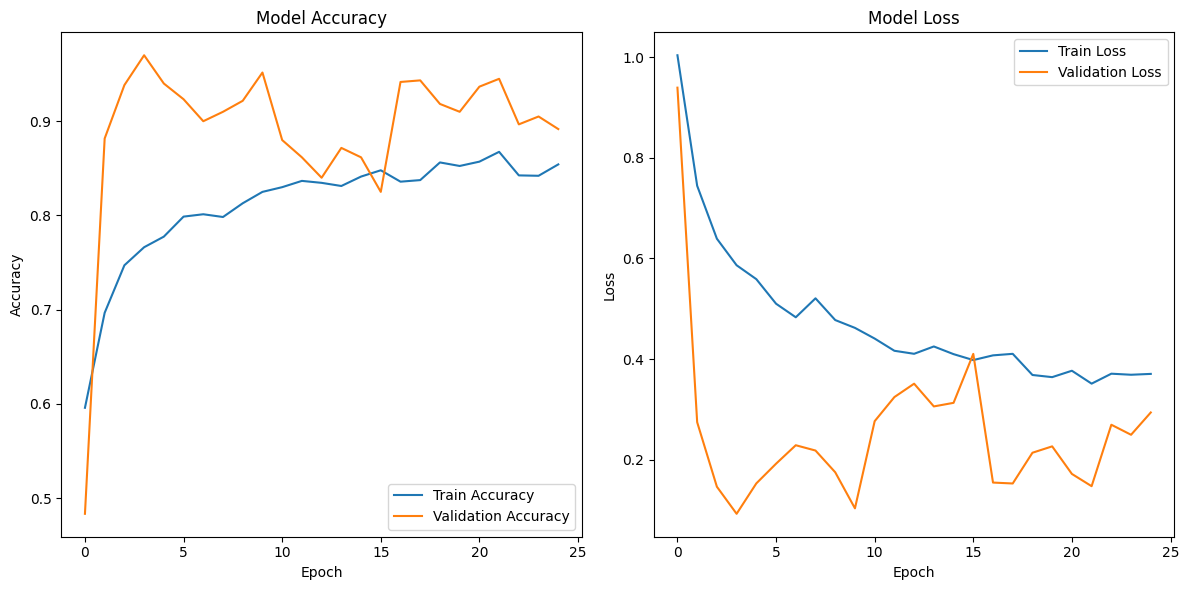

In [16]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [17]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
    # Load the image
    path = fn
    img = image.load_img(path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale

    # Make prediction
    predictions = vgg19.predict(img_array)
    predicted_class_index = np.argmax(predictions)

    # Get class labels from the training generator
    class_labels = list(train_generator.class_indices.keys())
    predicted_class_label = class_labels[predicted_class_index]

    print(f"The image is predicted to be a: {predicted_class_label}")

Saving cat_1.jpg to cat_1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
The image is predicted to be a: cats
